In [15]:
import math
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time
import sys

sys.path.append('../')
from BayesBackpropagation import *
import matplotlib.pyplot as plt
# plt.switch_backend('agg')

# Define training step for regression
def train(net, optimizer, data, target, NUM_BATCHES):
    #net.train()
    for i in range(NUM_BATCHES):
        net.zero_grad()
        x = data[i].reshape((-1, 1))
        y = target[i].reshape((-1,1))
        loss = net.BBB_loss(x, y)
        loss.backward()
        optimizer.step()

#Hyperparameter setting
INPUT_SHAPE = 1
TRAIN_EPOCHS = 900
SAMPLES = 5
TEST_SAMPLES = 10
BATCH_SIZE = 200
NUM_BATCHES = 10
TEST_BATCH_SIZE = 50
CLASSES = 1
PI = 0.25
SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(DEVICE)
SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(DEVICE)

# use GPU for computation if possible
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
def nonlinear_function(x):
    eps = np.random.normal(0, 0.02, size=x.shape)
    return (x + 0.3*np.sin(2*np.pi*(x + eps))
            + 0.3*np.sin(4*np.pi*(x + eps)) + eps)

# Load a dataset
def get_data(batch_size):
    # transform = transforms.Compose([transforms.ToTensor()])
    random_gen = np.random.default_rng(seed=123)
    train_data = random_gen.uniform(-0.1, 0.61, size=2000)
    train_targets = nonlinear_function(train_data)
    train_dataset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_targets))
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    test_data = np.linspace(-0.2, 1.2, 100)
    test_targets = nonlinear_function(test_data)
    test_dataset = TensorDataset(torch.Tensor(test_data), torch.Tensor(test_targets))
    test_loader = DataLoader(test_dataset, batch_size=10)

    return train_loader, test_loader

train_loader, test_loader = get_data(batch_size=200)

In [17]:
print('BBB Training Begins!')

#Declare Network
net = BayesianNetwork(inputSize = 1,\
                    CLASSES = CLASSES, \
                    layers=np.array([16,16,16]), \
                    activations = np.array(['relu','relu','relu','none']), \
                    SAMPLES = SAMPLES, \
                    BATCH_SIZE = BATCH_SIZE,\
                    NUM_BATCHES = NUM_BATCHES,\
                    hasScalarMixturePrior = True,\
                    PI = PI,\
                    SIGMA_1 = SIGMA_1,\
                    SIGMA_2 = SIGMA_2,\
                    GOOGLE_INIT= False).to(DEVICE)

#Declare the optimizer
optimizer = optim.SGD(net.parameters(),lr=1e-3,momentum=0.95)

for epoch in range(1, TRAIN_EPOCHS + 1):
    start = time.time()
    train_loss, train_acc = 0, 0
    # for i in range(NUM_BATCHES):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x = data.reshape((-1, 1))
        y = target.reshape((-1, 1))
        loss = net.BBB_loss(x, y)
        loss.backward()
        optimizer.step()

        train_loss += float(loss)

    if (epoch)%10 == 0:
        print('Epoch: ', epoch, 'Train loss:', train_loss / len(train_loader.dataset))
    
print('Training Ends!')



BBB Training Begins!
Epoch:  10 Train loss: 0.7293186416625976
Epoch:  20 Train loss: 0.7109746475219727
Epoch:  30 Train loss: 0.7008980102539063
Epoch:  40 Train loss: 0.6976784210205078
Epoch:  50 Train loss: 0.6949608764648437
Epoch:  60 Train loss: 0.6934564590454102
Epoch:  70 Train loss: 0.6954432525634766
Epoch:  80 Train loss: 0.6956352920532226
Epoch:  90 Train loss: 0.696118782043457
Epoch:  100 Train loss: 0.6948138885498046
Epoch:  110 Train loss: 0.6944177551269531
Epoch:  120 Train loss: 0.6933381042480469
Epoch:  130 Train loss: 0.6942536087036133
Epoch:  140 Train loss: 0.6919989776611328
Epoch:  150 Train loss: 0.6941752166748046
Epoch:  160 Train loss: 0.6940082321166993
Epoch:  170 Train loss: 0.6946827087402344
Epoch:  180 Train loss: 0.6928960876464844
Epoch:  190 Train loss: 0.6959164123535156
Epoch:  200 Train loss: 0.6941926345825196
Epoch:  210 Train loss: 0.6922823028564453
Epoch:  220 Train loss: 0.6946539916992187
Epoch:  230 Train loss: 0.6926475601196289


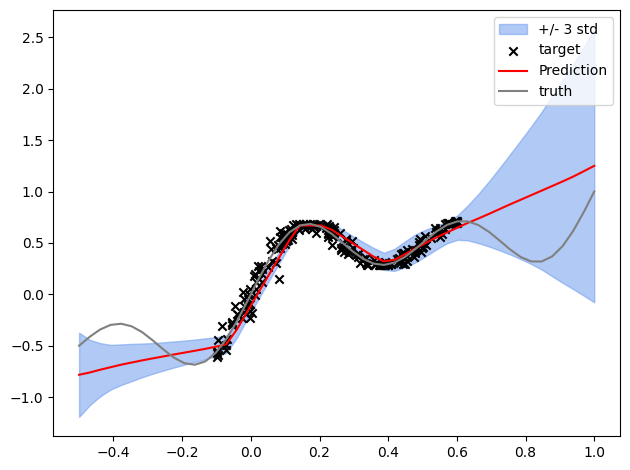

In [18]:
Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))
x_test = np.linspace(-0.5, 1,TEST_BATCH_SIZE)
y_test = x_test + 0.3*np.sin(2*np.pi*x_test) + 0.3*np.sin(4*np.pi*x_test)
X_test = Var(x_test)

#Testing
outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
for i in range(TEST_SAMPLES):
    outputs[i] = net.forward(X_test)
outputs[TEST_SAMPLES] = net.forward(X_test)
pred_mean = outputs.mean(0).data.cpu().numpy().squeeze(1) #Compute mean prediction
pred_std = outputs.std(0).data.cpu().numpy().squeeze(1) #Compute standard deviation of prediction for each data point

#Visualization
plt.fill_between(x_test, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                    color='cornflowerblue', alpha=.5, label='+/- 3 std')
plt.scatter(x, y,marker='x', c='black', label='target')
plt.plot(x_test, pred_mean, c='red', label='Prediction')
plt.plot(x_test, y_test, c='grey', label='truth')
plt.legend()
plt.tight_layout()
plt.show()